In [1]:
import pandas as pd
from sklearn.base import BaseEstimator
import numpy as np
#Para convertir el dataset de atributos categoricos a numericos
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt
from numpy import array
from numpy import asarray

#################STAGE 1: SELECCION DEL DATASET -> Chess End-Game -- King+Rook versus King+Pawn on a7
# load dataset 
dataset =pd.read_csv("chess.txt", header=None)

#Attribute 36 -> targets
###############STAGE 2: PRE-PROCESSING //// SIN VALORES FALTANTES
#DATASET REINDEX================================
random_index = [0 for x in range(dataset.shape[0])]
for i in range(0, dataset.shape[0]):
    random_index[i]=i
np.random.shuffle(random_index) #REVOLVER INDICES DEL ARRAY
#DATASET REINDEX
dataset = pd.DataFrame(dataset)
dataset = dataset.reindex(index=random_index)
#CONVERTIR A MATRIZ PARA REINICIAR INDICES DE LAS NUEVAS FILAS
dataset = dataset.as_matrix()
#CONVERTIR A DATAFRAME DE NUEVO UNA VEZ REINICIADOS LOS INDICES CON LAS NUEVAS FILAS
dataset = pd.DataFrame(dataset)
#END DATASET REINDEX===============================

##TOMAR SOLO UNAS CUANTAS FILAS DEL DATASET DEBIDO AL GRAN TAMAÑO QUE TIENE
n_filas=500
data_chess = [[0 for x in range(dataset.shape[1] - 1)] for y in range(n_filas)]
targets_chess = [0 for x in range(n_filas)]

for i in range(0, n_filas):
    for j in range(0, dataset.shape[1]- 1):
        data_chess[i][j] = dataset.at[i,j]
#LEER TARGETS DEL DATASET : WON -> 1       NOWIN -> 0
for i in range(0, n_filas):
    if(dataset.at[i,36] == "won"):
        targets_chess[i] = 1
    else:
        targets_chess[i]=0

#CONVERSION DEL DATASET DE CATEGORICO A NUMERICO

#INSTANCIA DE LABEL ENCODER
label_encoder = LabelEncoder()
data_chess_label_encoder = [[0 for x in range(dataset.shape[1] - 1)] for y in range(n_filas)]
#conversion de categorico a numerico con label encoder
for i in range(0, n_filas):
    data_chess_label_encoder[i] = label_encoder.fit_transform(data_chess[i])
#Aplicar one hot encoder a la transformacion de label encoder para finalizar transformacion categorica a numerica
enc = OneHotEncoder(sparse=False)
chess_oneHotEncoder = enc.fit_transform(data_chess_label_encoder)
chess_oneHotEncoder = pd.DataFrame(chess_oneHotEncoder) #NUEVO DATASET NUMERICO

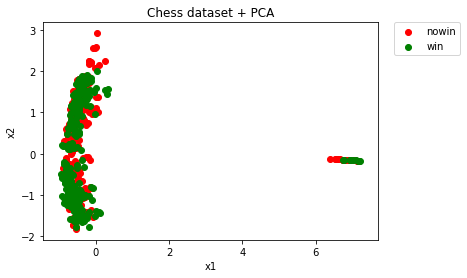

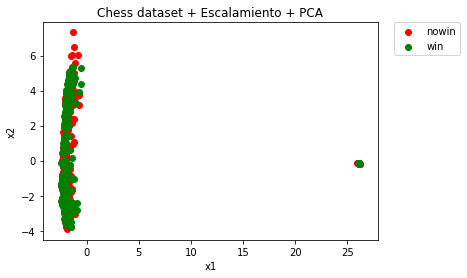

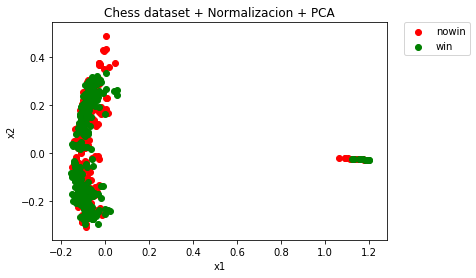

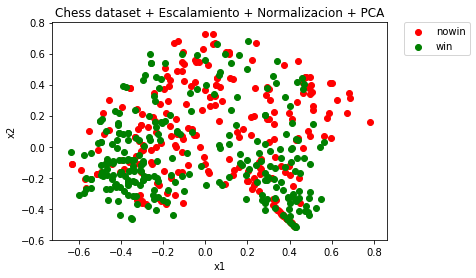

In [2]:
#Grafica de grupos
#LA SIGUIENTE RECIBE COMO PARAMETROS EL DATASET, LOS TARGETS Y EL TITULO DE LA GRAFICA, POSTERIORMENTE PROCEDE A GRAFICAR
def graficar(dataset, targets, title):
    colors=['red','green']
    targets_name = ["nowin","win"]
    for i in range(len(colors)):
        x = dataset[:,0][targets==i]
        y= dataset[:,1][targets==i]
        plt.scatter(x,y,c=colors[i])
        plt.legend(targets_name,bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.title(title)
    plt.show()
    
%matplotlib inline
#Graficar visualizacion de datos

#Reduccion de dimensiones con PCA
pca = PCA(n_components=2)
#fit and transform the data to the model
reduce_data_pca = pca.fit_transform(chess_oneHotEncoder)

targets_chess = asarray(targets_chess)

#########################Grafica PCA solamente
graficar(reduce_data_pca, targets_chess, "Chess dataset + PCA")

########################APLICACION DE ESCALAMIENTO : GRAFICA ESCALAMIENTO + PCA
Matrix_scaled = preprocessing.scale(chess_oneHotEncoder)
pca = PCA(n_components=2)
#PCA
reduce_data_pca_e = pca.fit_transform(Matrix_scaled)
graficar(reduce_data_pca_e, targets_chess,  "Chess dataset + Escalamiento + PCA")

########################APLICACION DE NORMALIZACION: GRAFICA Normalizacion + PCA
Matrix_np = np.asanyarray(chess_oneHotEncoder)
Matrix_normalizada = preprocessing.normalize(Matrix_np, norm='l2')
#PCA
pca = PCA(n_components=2)
reduce_data_pca_n = pca.fit_transform(Matrix_normalizada)
graficar(reduce_data_pca_n, targets_chess,  "Chess dataset + Normalizacion + PCA")

########################APLICACION DE ESCALAMIENTO Y NORMALIZACION: GRAFICA Escalamiento + Normalizacion + PCA
Matrix_np_2 = np.asanyarray(Matrix_scaled)
Matrix_normalizada_2 = preprocessing.normalize(Matrix_np_2, norm='l2')
#PCA
pca = PCA(n_components=2)
reduce_data_pca_e_n = pca.fit_transform(Matrix_normalizada_2)
graficar(reduce_data_pca_e_n, targets_chess,  "Chess dataset + Escalamiento + Normalizacion + PCA")

In [3]:
#NaiveBayes ADAPTADO
class Bayes(BaseEstimator):
    dataset = [] #dataset
    targets = [] #array contenedor de las etiquetas de cada registro del dataset
    targets_name = [] #array contenedor de todas las posibles etiquetas
    new_tuple = [] #nuevo registro: Contenedor de F1..Fn (atributos)
    aProbF = [] #array contenedor de probabilidades de Fs (columnas del dataset)
    aProbC = [] #array contenedor de probabilidades de C (todas las posibles etiquetas)
    aProbC_new_tuple = [] #array contenecdor de probabilidades de C (respecto al nuevo registro)
    
    #Constructor recibe como parametros: targets_name
    def __init__(self, targets_name):
        self.targets_name = targets_name
    #Metodo fit, el cual calcula las probabilidades para ambas etiquetas (positiva y negativa) asi como tambien
    #asigna el dataset de entrenamiento y el target a las variables correspondientes
    def fit(self, X, y):
        self.dataset = self.verifyType(X)
        self.targets = y
        self.initArrays()
        for i in range(0, len(self.targets_name)):
            cont = 0.0
            for j in range(0, len(self.targets)):
                if(self.targets_name[i] == self.targets[j]):
                    cont = cont + 1.0
            self.aProbC[i] = cont / len(self.targets)
        return self
    #Metodo predict_proba, recibe como parametro el dataset de validacion y retorna para cada fila de este...
    #la probabilidad obtenida de la etiqueta positiva
    def predict_proba(self, X):
        y = [0.0 for y in range( len(X) )]
        for i in range(0, len(X) ):
            y[i] = self.perform(X[i])
        y = asarray(y)
        return y
     
    #funcion que verifica si el dataset recibido como parametro es de tipo DataFrame, si no es asi, se convierte a este tipo
    def verifyType(self, X):
        if(not type(X)==pd.DataFrame):
            X = pd.DataFrame(data=X)
        return X
    #Metodo que inicializa los arrays de probabilidades
    def initArrays(self):
        self.aProbF = [0.0 for x in range(self.dataset.shape[1])]
        self.aProbC = [0.0 for x in range(len(self.targets_name))]
        self.aProbC_new_tuple = [0.0 for x in range(len(self.targets_name))]
        
    #Metodo que ejecuta el algoritmo
    def perform(self, new_tuple):
        for x in range(0, len(self.targets_name)):
            cont = 0.0
            self.aProbF = [0.0 for d in range(self.dataset.shape[1])]
            for i in range(0, self.dataset.shape[0]):
                if(self.targets_name[x]==self.targets[i]):
                    cont = cont + 1.0
                    for j in range(0, self.dataset.shape[1]):
                        if(self.dataset.at[i,j] == new_tuple[j]):
                            self.aProbF[j] = self.aProbF[j] + 1.0
            self.exProbFandC(cont,x)
        return self.getLabel()
        
    #Metodo que calcula las probabilidades de cada etiqueta posible
    def exProbFandC(self, norm, indC):
        acum = 1.0
        for i in range(0, len(self.aProbF)):
            self.aProbF[i] = self.aProbF[i] / norm
            acum = acum * self.aProbF[i]
        self.aProbC_new_tuple[indC] = self.aProbC[indC] * acum
    
    #Funcion que retorna la probabilidad de la etiqueta positiva (en este caso la etiqueta es 1)
    def getLabel(self):
        return self.aProbC_new_tuple[1]

In [4]:
#ROC
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

#Funcion graficar_roc, recibe como parametros el dataset, los targets, el numero de renanadas, la variable que contiene..
#el clasificador (algoritmo naive bayes, svm o random forest) y Nb el cual es una variable bandera que en caso de ser 1..
#se realiza un cambio en la clase roc_curve esto para adaptar el array de retorno 
def graficar_roc(X, y, n_folds, classifier, titleGraph,Nb):
    #Si el dataset no es de tipo dataframe, se convierte
    if(not type(X) == pd.DataFrame ):
        X = pd.DataFrame(X)
    n_samples, n_features = X.shape
    X = np.c_[X, random_state.randn(n_samples,0)]
    #se asigna el numero de rebanadas
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    #a continuacion se itera tantas veces como rebenadas se seleccionaron y se ingresan dataset de validacion..
    #al algoritmo clasificador ademas se manda llamar el metodo predict_proba y retorna el array de probabilidad positiva
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        if(Nb==1): #adaptacion para Naive Bayes
            fpr, tpr, thresholds = roc_curve(y[test], probas_)
        else: #Para cualquier otro algoritmo
            fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr) #calculo de area bajo la curva
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc)) #calculo de area bajo la curva de cada rebanada

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8) #indicador de linea Luck

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr) #calculo de area bajo la curva promedio
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0) #calculo de desviacion estandar
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(titleGraph)
    plt.legend(loc="lower right")
    plt.show()

    

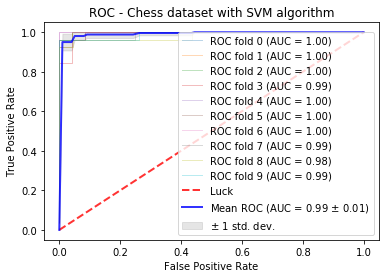

In [5]:
#ROC con algoritmo Maquina de Soporte Vectorial : Se crea el clasificador como una instancia de la SVC y se ingresan
#el dataset numerico, los targets, numero de rebanadas=10, el clasificador y el titulo de la grafica como entrada de la funcion graficar_roc
random_state = np.random.RandomState(0)
classifier =svm.SVC(kernel='linear', probability=True,random_state=random_state)
graficar_roc(chess_oneHotEncoder, targets_chess, 10, classifier, "ROC - Chess dataset with SVM algorithm",0)

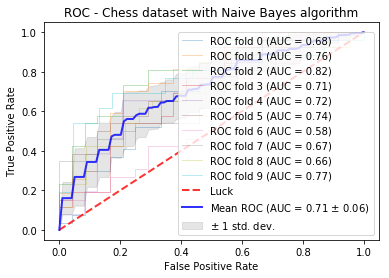

In [6]:
#ROC con algoritmo Naive Bayes : Se crea el clasificador como una instancia de la Bayes y se ingresan
#el dataset categorico, los targets, numero de rebanadas=10, el clasificador y el titulo de la grafica como entrada de la funcion graficar_roc
targets_name_chess = [0,1]
classifier = Bayes(targets_name_chess)
#data_chess = pd.DataFrame(data_chess)
graficar_roc(data_chess, targets_chess, 10, classifier, "ROC - Chess dataset with Naive Bayes algorithm",1)

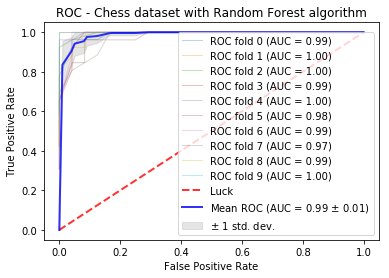

In [7]:
#ROC con algoritmo Random Forest : Se crea el clasificador como una instancia de la RandomForestClassifier y se ingresan
#el dataset numerico, los targets, numero de rebanadas=10, el clasificador y el titulo de la grafica como entrada de la funcion graficar_roc
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
graficar_roc(chess_oneHotEncoder, targets_chess, 10, classifier, "ROC - Chess dataset with Random Forest algorithm",0)